# Laboratory work 2. Rayleight and Rician channel modelling

Cherniavskiy Dmitriy. Group 5197

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as spf
import ModulationPy as modpy
import pandas as pd
%matplotlib inline

## Task

![scheme.png](./scheme.png)

## Channel models and functions

In [2]:
class Channel:
    def __init__(self, EbNo, M, rng_seed=42):
        self.rng = np.random.default_rng(seed=rng_seed)
        self.EbNo = EbNo
        self.h = None
        self.additive_noise = None
        self.Es = None # energy per simbol
        self.No = None # noise spectral density
    
    def __call__(self, s):
        self.calc_params(s)
        return self.noising(s)
    
    def fading(self, s):
        if np.iscomplexobj(s):
            self.h = (self.rng.normal(loc=0, scale=1, size=s.shape) +
                      1j*self.rng.normal(loc=0, scale=1, size=s.shape))
        else:
            self.h = self.rng.normal(loc=0, scale=1, size=s.shape)
    
    def add_noises(self, s):
        if np.iscomplexobj(s):
            self.additive_noise = (self.rng.normal(loc=0, scale=1, size=s.shape) +
                                   1j*self.rng.normal(loc=0, scale=1, size=s.shape))
        else:
            self.additive_noise = self.rng.normal(loc=0, scale=1, size=s.shape)
    
    def calc_params(self, s):
        self.Es = np.mean(abs(s)**2)
        self.N0 = self.Es/((10**(self.EbNo/10))*np.log2(self.M))
    
    def forward(self, s):
        self.fading(s)
        self.add_noises(s)
        s_out = (s * self.h + self.additive_noise) / self.h # division by h is zero-forcing equalizing
        return s_out
                     

    
class RayleightChannel(Channel):
    def __init__(self, EbNo, M, k=None):
        super(RayleightChannel, self).__init__(EbNo, M)
        self.M = M
            
        if k:
            self.fading = self.rician_fading
            self.K = k
        else:
            self.fading = self.rayleight_fading
            
        self.add_noises = self.awgn
        
    def __call__(self, s):
        if np.isrealobj(s):
            raise ValueError('signal must be array of complex values')
        self.calc_params(s)
        return self.forward(s)

    def rayleight_fading(self, s): # [2] Rayleight fading
        # rayleight fading is case of rician fading where K=0
        # then for this process mu=0, sigma=1/sqrt(2)
        self.h = (self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=s.shape) +
              1j * self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=s.shape))
    
    def rician_fading(self, s): 
        K = self.K
        self.h = (np.sqrt(K / (K + 1)) + np.sqrt(1 / (K + 1)) * np.sqrt(1 / 2) *
                  self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=len(s)) +
                  1j * self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=len(s)))
    
    def awgn(self, s): # [1] AWGN function   
        self.additive_noise = (self.rng.normal(loc=0, scale=np.sqrt(self.N0 / 2), size=s.shape) +
                            1j * self.rng.normal(loc=0, scale=np.sqrt(self.N0 / 2), size=s.shape))

    
class RicianChannel(Channel):
    def __init__(self, EbNo, M, k):
        super(RicianChannel, self).__init__(EbNo, M)
        
        self.M = M 
        self.fading = self.rician_fading
        self.K = k 
        self.add_noises = self.awgn
        
    def __call__(self, s):
        if np.isrealobj(s):
            raise ValueError('signal must be array of complex values')
        self.calc_params(s)
        return self.forward(s)
    
    def rician_fading(self, s): 
        self.h = (np.sqrt(self.K / (self.K + 1)) + np.sqrt(1 / (self.K + 1)) * np.sqrt(1 / 2) *
                  self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=len(s)) +
                  1j * self.rng.normal(loc=0, scale=np.sqrt(1 / 2), size=len(s)))
    
    def awgn(self, s): # [1] AWGN function   
        self.additive_noise = (self.rng.normal(loc=0, scale=np.sqrt(self.N0 / 2), size=s.shape) +
                            1j * self.rng.normal(loc=0, scale=np.sqrt(self.N0 / 2), size=s.shape))
        
    


In [3]:
def bit_error(msg, demod_msg):
    if len(msg) != len(demod_msg):
        raise Exception('msg and demod msg must be the same length')
    errors = 0
    for sym_msg, sym_demod_msg in zip(msg, demod_msg):
        
        if sym_msg != sym_demod_msg:
            errors+=1
    return errors/len(msg)
    

def ber_theory_psk(EbN0dBs, M): # [3] BER
    if M > 4:
        return spf.erfc(np.sqrt(np.log2(M)*10**(EbN0dBs/10))*np.sin(np.pi/M))/np.log2(M)
    else:
        return 0.5*spf.erfc(np.sqrt(10**(EbN0dBs/10)))


def ber_theory_qam(EbN0dBs, M):
    EbNo = 10**(EbN0dBs/10)
    pb = 2*((np.sqrt(M))/(M*np.log2(M))
            *spf.erfc(np.sqrt((3*np.log2(M)*EbNo)/(2*(M-1)))))
    return pb

In [4]:
class MsgSource:
    def __init__(self, M, len_msg):
        self.M = M
        self.len_msg = len_msg
        self.sym_generator = np.random.default_rng(seed=42).integers
        self.sym_gen_params = {'low':0, 'high':2, 'size':np.log2(self.M).astype(int)}
        
    def gen_sym(self):
        sym = self.sym_generator(**self.sym_gen_params)
        return sym
    
    def gen_msg(self):
        msg = []
        for n_sym in range(self.len_msg):
            msg.append(self.gen_sym())
        return np.ravel(msg)

## Simulation

### Rayleight Channel

In [5]:
M = 8 # M must be power of 2
print('N = ', np.log2(M))
msg_len = 1000
EbNo_array = np.arange(-10, 25) # dB
source = MsgSource(M, msg_len)

modulator = modpy.PSKModem(M, np.pi/4,
                 bin_input=True,
                 soft_decision=False,
                 bin_output=True)

N =  3.0


In [6]:
channel = RayleightChannel(EbNo=0, M=M)

msg = source.gen_msg()
out_modulator = modulator.modulate(msg)
demod_msg_before_ch = modulator.demodulate(msg)
out_channel = channel(out_modulator)
demod_msg = modulator.demodulate(out_channel)

ber = bit_error(msg, demod_msg)
print(f'Bit error ratio is {ber}')

Bit error ratio is 0.18766666666666668


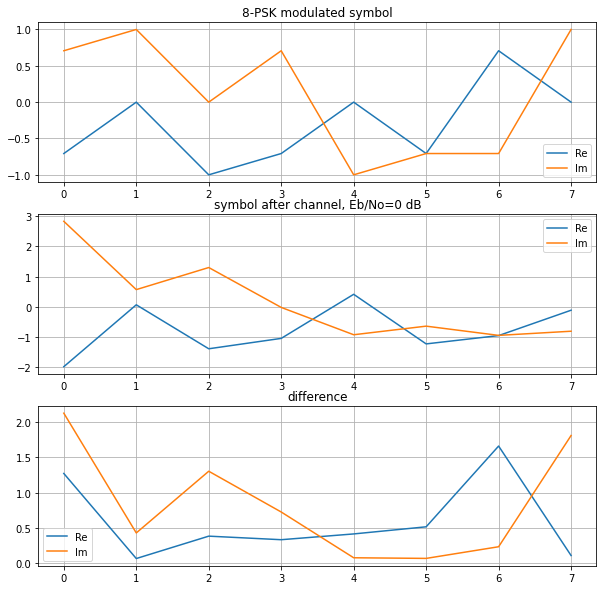

In [7]:
fig, axs = plt.subplots(3, figsize=(10,10))

axs[0].plot(range(len(out_modulator[:M])), out_modulator[:M].real)
axs[0].plot(range(len(out_modulator[:M])), out_modulator[:M].imag)
axs[0].grid()
axs[0].set_title(f'{M}-PSK modulated symbol')
axs[0].legend(['Re', 'Im'])

axs[1].plot(range(len(out_channel[:M])), out_channel[:M].real)
axs[1].plot(range(len(out_channel[:M])), out_channel[:M].imag)
axs[1].grid()
axs[1].set_title('symbol after channel, Eb/No=0 dB')
axs[1].legend(['Re', 'Im'])

axs[2].plot(range(len(out_channel[:M])), np.abs(out_modulator[:M].real - out_channel[:M].real))
axs[2].plot(range(len(out_channel[:M])), np.abs(out_modulator[:M].imag - out_channel[:M].imag))
axs[2].grid()
axs[2].set_title('difference')
axs[2].legend(['Re', 'Im']);


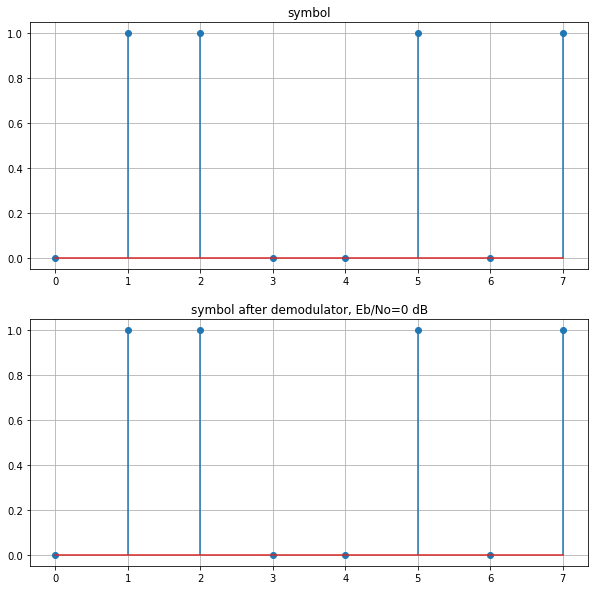

In [8]:
fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].stem(range(len(msg[:M])), msg[:M])
axs[0].grid()
axs[0].set_title('symbol')

axs[1].stem(range(len(demod_msg[:M])), demod_msg[:M])
axs[1].grid()
axs[1].set_title('symbol after demodulator, Eb/No=0 dB');

In [9]:
N = 5
M_array = [2**n for n in range(1, N+1)]
M_array

[2, 4, 8, 16, 32]

In [10]:
bers = []
for M in M_array:
    print(f'for M ={M}, N = {np.log2(M)}')
    
    source = MsgSource(M, msg_len)

    modulator = modpy.PSKModem(M, np.pi/4,
                     bin_input=True,
                     soft_decision=False,
                     bin_output=True)
    ber_array = []
    for ebno in EbNo_array:
        channel = RayleightChannel(EbNo=ebno, M=M)

        msg = source.gen_msg()
        out_modulator = modulator.modulate(msg)
        demod_msg_before_ch = modulator.demodulate(msg)
        out_channel = channel(out_modulator)
        demod_msg = modulator.demodulate(out_channel)

        ber = bit_error(msg, demod_msg)
        ber_array.append(ber)
    bers.append(ber_array)

for M =2, N = 1.0
for M =4, N = 2.0
for M =8, N = 3.0
for M =16, N = 4.0
for M =32, N = 5.0


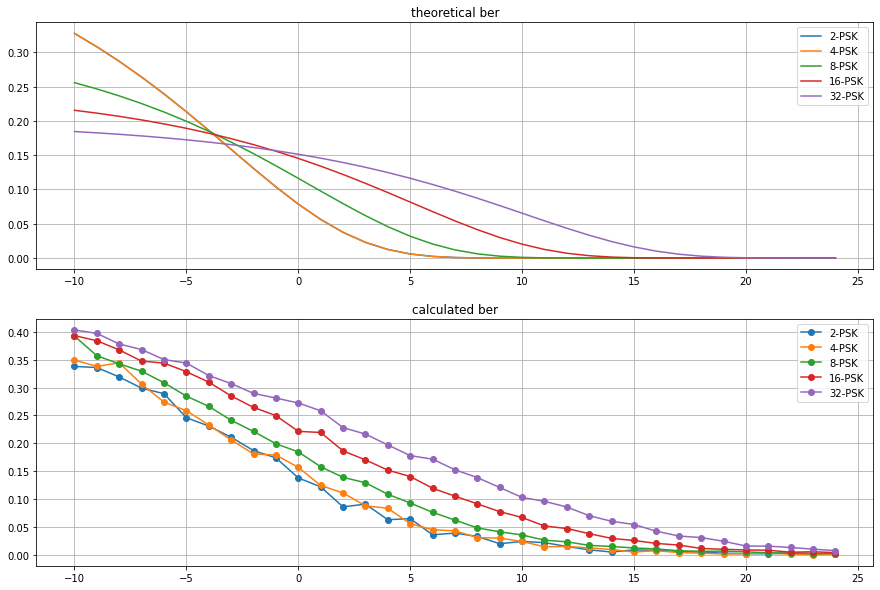

In [11]:
fig, axs = plt.subplots(2, figsize=(15,10))

for i, M in enumerate(M_array):
    axs[0].plot(EbNo_array, ber_theory_psk(EbNo_array, M))
    axs[1].plot(EbNo_array, bers[i], '-o')

axs[0].grid()
axs[1].grid()
axs[0].set_title(f'theoretical ber')
axs[1].set_title(f'calculated ber')

axs[0].legend([f'{M}-PSK' for M in M_array])
axs[1].legend([f'{M}-PSK' for M in M_array]);

In [12]:
N = 4
M_array = [4**n for n in range(1, N+1)]
M_array

[4, 16, 64, 256]

In [13]:
bers = []
for M in M_array:
    print(f'for M ={M}, N = {np.log2(M)}')
    
    source = MsgSource(M, msg_len)

    modulator = modpy.QAMModem(M, 
                     bin_input=True,
                     soft_decision=False,
                     bin_output=True)
    ber_array = []
    for ebno in EbNo_array:
        channel = RayleightChannel(EbNo=ebno, M=M)

        msg = source.gen_msg()
        out_modulator = modulator.modulate(msg)
        demod_msg_before_ch = modulator.demodulate(msg)
        out_channel = channel(out_modulator)
        demod_msg = modulator.demodulate(out_channel)

        ber = bit_error(msg, demod_msg)
        ber_array.append(ber)
    bers.append(ber_array)

for M =4, N = 2.0
for M =16, N = 4.0
for M =64, N = 6.0
for M =256, N = 8.0


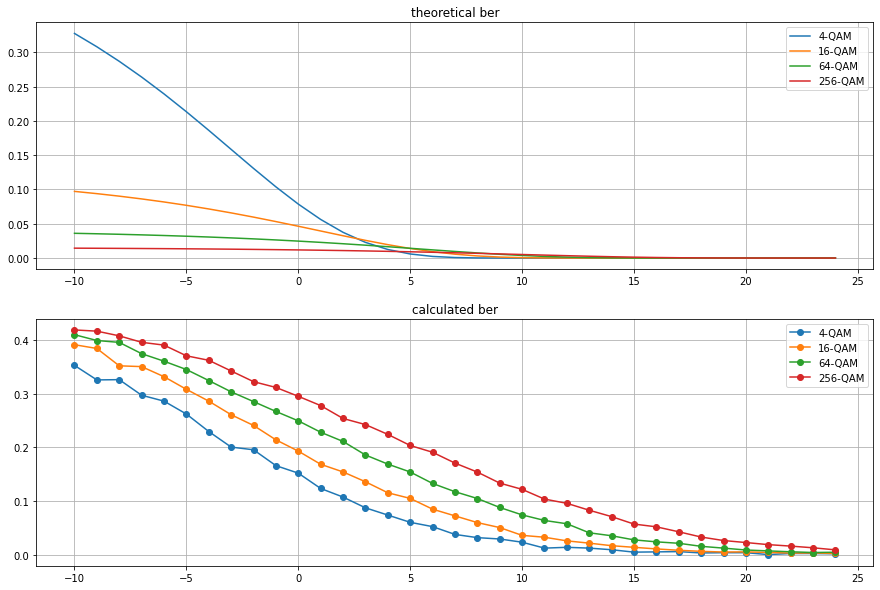

In [14]:
fig, axs = plt.subplots(2, figsize=(15,10))

for i, M in enumerate(M_array):
    axs[0].plot(EbNo_array, ber_theory_qam(EbNo_array, M))
    axs[1].plot(EbNo_array, bers[i], '-o')

axs[0].grid()
axs[1].grid()
axs[0].set_title(f'theoretical ber')
axs[1].set_title(f'calculated ber')

axs[0].legend([f'{M}-QAM' for M in M_array])
axs[1].legend([f'{M}-QAM' for M in M_array]);

### Rician Channel

In [15]:
M = 8 # M must be power of 2
print('N = ', np.log2(M))
msg_len = 1000
EbNo_array = np.arange(-10, 25) # dB
source = MsgSource(M, msg_len)

modulator = modpy.PSKModem(M, np.pi/4,
                 bin_input=True,
                 soft_decision=False,
                 bin_output=True)

N =  3.0


In [16]:
channel = RicianChannel(EbNo=0, M=M, k=0.6)

msg = source.gen_msg()
out_modulator = modulator.modulate(msg)
demod_msg_before_ch = modulator.demodulate(msg)
out_channel = channel(out_modulator)
demod_msg = modulator.demodulate(out_channel)

ber = bit_error(msg, demod_msg)
print(f'Bit error ratio is {ber}')

Bit error ratio is 0.16733333333333333


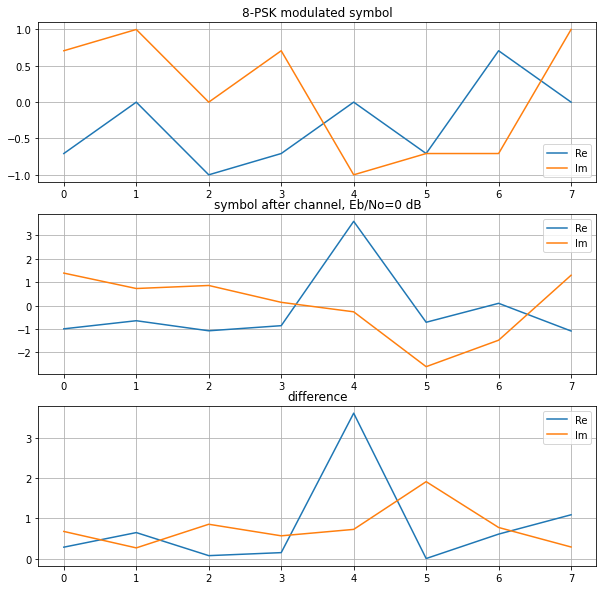

In [17]:
fig, axs = plt.subplots(3, figsize=(10,10))

axs[0].plot(range(len(out_modulator[:M])), out_modulator[:M].real)
axs[0].plot(range(len(out_modulator[:M])), out_modulator[:M].imag)
axs[0].grid()
axs[0].set_title(f'{M}-PSK modulated symbol')
axs[0].legend(['Re', 'Im'])

axs[1].plot(range(len(out_channel[:M])), out_channel[:M].real)
axs[1].plot(range(len(out_channel[:M])), out_channel[:M].imag)
axs[1].grid()
axs[1].set_title('symbol after channel, Eb/No=0 dB')
axs[1].legend(['Re', 'Im'])

axs[2].plot(range(len(out_channel[:M])), np.abs(out_modulator[:M].real - out_channel[:M].real))
axs[2].plot(range(len(out_channel[:M])), np.abs(out_modulator[:M].imag - out_channel[:M].imag))
axs[2].grid()
axs[2].set_title('difference')
axs[2].legend(['Re', 'Im']);


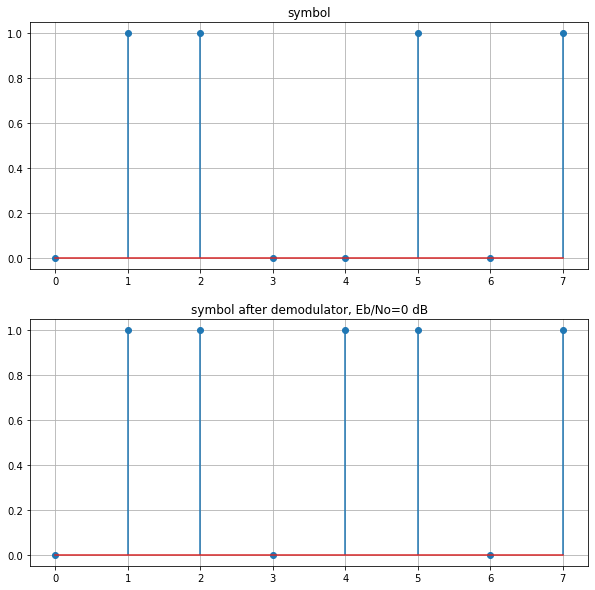

In [18]:
fig, axs = plt.subplots(2, figsize=(10,10))

axs[0].stem(range(len(msg[:M])), msg[:M])
axs[0].grid()
axs[0].set_title('symbol')

axs[1].stem(range(len(demod_msg[:M])), demod_msg[:M])
axs[1].grid()
axs[1].set_title('symbol after demodulator, Eb/No=0 dB');

In [19]:
N = 5
M_array = [2**n for n in range(1, N+1)]
M_array

[2, 4, 8, 16, 32]

In [20]:
bers = []
for M in M_array:
    print(f'for M ={M}, N = {np.log2(M)}')
    
    source = MsgSource(M, msg_len)

    modulator = modpy.PSKModem(M, np.pi/4,
                     bin_input=True,
                     soft_decision=False,
                     bin_output=True)
    ber_array = []
    for ebno in EbNo_array:
        channel = RicianChannel(EbNo=ebno, M=M, k=0.6)

        msg = source.gen_msg()
        out_modulator = modulator.modulate(msg)
        demod_msg_before_ch = modulator.demodulate(msg)
        out_channel = channel(out_modulator)
        demod_msg = modulator.demodulate(out_channel)

        ber = bit_error(msg, demod_msg)
        ber_array.append(ber)
    bers.append(ber_array)

for M =2, N = 1.0
for M =4, N = 2.0
for M =8, N = 3.0
for M =16, N = 4.0
for M =32, N = 5.0


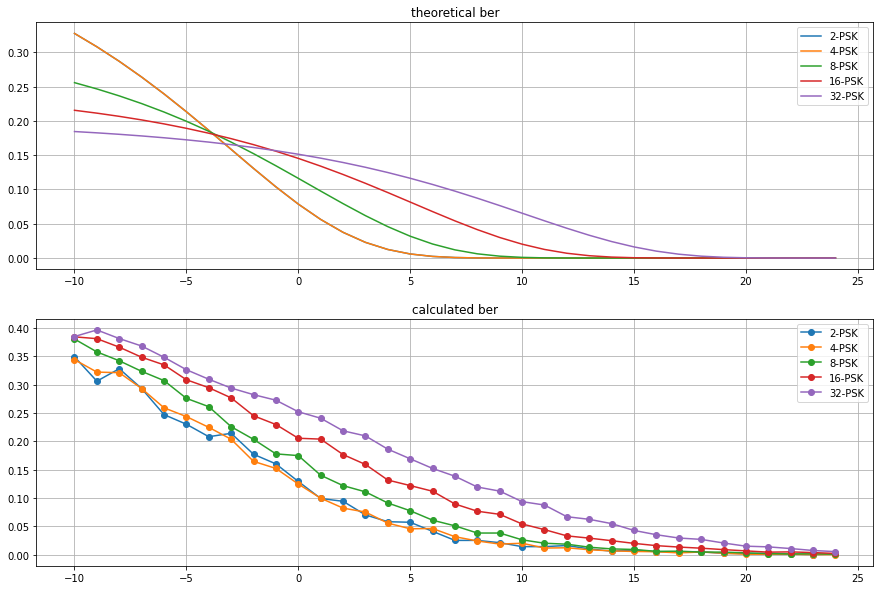

In [21]:
fig, axs = plt.subplots(2, figsize=(15,10))

for i, M in enumerate(M_array):
    axs[0].plot(EbNo_array, ber_theory_psk(EbNo_array, M))
    axs[1].plot(EbNo_array, bers[i], '-o')

axs[0].grid()
axs[1].grid()
axs[0].set_title(f'theoretical ber')
axs[1].set_title(f'calculated ber')

axs[0].legend([f'{M}-PSK' for M in M_array])
axs[1].legend([f'{M}-PSK' for M in M_array]);

In [22]:
N = 4
M_array = [4**n for n in range(1, N+1)]
M_array

[4, 16, 64, 256]

In [23]:
bers = []
for M in M_array:
    print(f'for M ={M}, N = {np.log2(M)}')
    
    source = MsgSource(M, msg_len)

    modulator = modpy.QAMModem(M, 
                     bin_input=True,
                     soft_decision=False,
                     bin_output=True)
    ber_array = []
    for ebno in EbNo_array:
        channel = RicianChannel(EbNo=ebno, M=M, k=0.6)

        msg = source.gen_msg()
        out_modulator = modulator.modulate(msg)
        demod_msg_before_ch = modulator.demodulate(msg)
        out_channel = channel(out_modulator)
        demod_msg = modulator.demodulate(out_channel)

        ber = bit_error(msg, demod_msg)
        ber_array.append(ber)
    bers.append(ber_array)

for M =4, N = 2.0
for M =16, N = 4.0
for M =64, N = 6.0
for M =256, N = 8.0


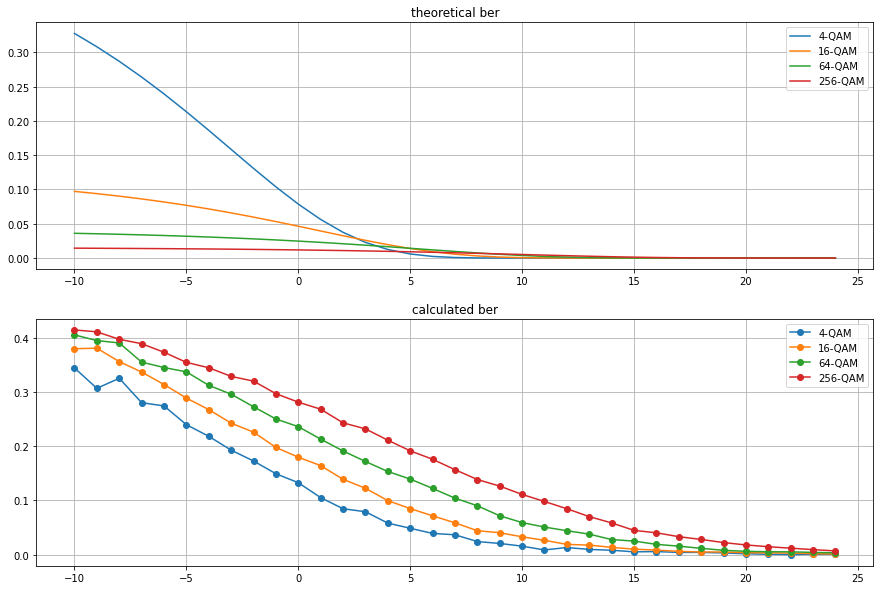

In [24]:
fig, axs = plt.subplots(2, figsize=(15,10))

for i, M in enumerate(M_array):
    axs[0].plot(EbNo_array, ber_theory_qam(EbNo_array, M))
    axs[1].plot(EbNo_array, bers[i], '-o')

axs[0].grid()
axs[1].grid()
axs[0].set_title(f'theoretical ber')
axs[1].set_title(f'calculated ber')

axs[0].legend([f'{M}-QAM' for M in M_array])
axs[1].legend([f'{M}-QAM' for M in M_array]);

## References

1) AWGN function: https://www.gaussianwaves.com/2015/06/how-to-generate-awgn-noise-in-matlaboctave-without-using-in-built-awgn-function/


2) Rician and rayleight fading: https://nbviewer.org/github/kirlf/CSP/blob/master/MIMO/RicianFlatFadingMATLAB.ipynb


3) BER: https://github.com/kirlf/ModulationPy#3-bit-error-ratio-performance


4) BER fading: https://www.mathworks.com/help/comm/ug/analytical-expressions-and-notations-used-in-ber-analysis.html#bq4230n